# Guided Project: Answering Business Questions Using SQL

Practice the SQL skill by
- write a SQL query to extract the relevant data
- create plots where necessary to visualize the data
- write a short paragraph, drawing conclusions and explaining the data or visualization

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

db = 'chinook.db'

# Defining functions to run sql easily
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
    
def show_tables():
    q = '''
    SELECT 
        name, 
        type
    FROM sqlite_master
    WHERE type IN ("table", "view")
    '''
    return run_query(q)

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


A query that returns each genre, with number of tracks sold in the USA in absolute number and in percentages. Create a plot to show the data

In [3]:
q_usa_tracks = '''
WITH usa_tracks AS
        (
        SELECT
            il.track_id
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        WHERE i.billing_country = 'USA'
        )
        
SELECT 
    g.name genre,
    COUNT(*) number_of_tracks,
    CAST(COUNT(*) as FLOAT) / (SELECT COUNT(*) FROM usa_tracks) percentage
    FROM usa_tracks ut
    INNER JOIN track t ON t.track_id = ut.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    GROUP BY 1 ORDER BY 2 DESC
    LIMIT 10
'''
genre_sales_usa = run_query(q_usa_tracks)

In [4]:
genre_sales_usa

,genre,number_of_tracks,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


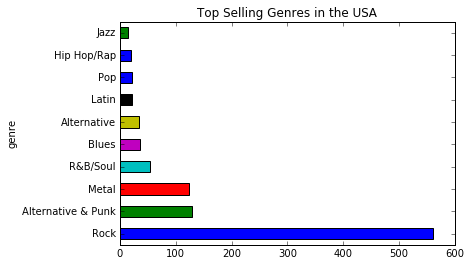

In [5]:
genre_sales_usa.set_index('genre')['number_of_tracks'].plot.barh(title='Top Selling Genres in the USA')

The rock genre is the top selling music in the USA. Based on the result, the top 3 genres are somehow related to the kind of music. 

A query that finds the total dollar amount of sales assigned to each sales support agent within the company

In [6]:
q_total_sales_employee = '''
WITH rep_total_sales AS
    (
    SELECT
        support_rep_id,
        SUM(i.total) total_sales
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY 1
    )

SELECT 
    first_name || " " || last_name employee,
    hire_date,
    rts.total_sales
FROM employee e
INNER JOIN rep_total_sales rts ON rts.support_rep_id = e.employee_id
'''
employee_sales_total = run_query(q_total_sales_employee)

In [7]:
employee_sales_total

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


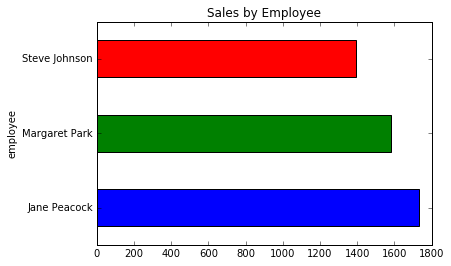

In [8]:
employee_sales_total.set_index('employee')['total_sales'].plot.barh(title='Sales by Employee')

Based on the data, the earlist hired employee has the highest total sales.

A query that collates data on purchases from different countries where a country has only one customer, collect them into an "Other" group. The result should be sorted by the total sales from highest to lowest, with "Other" group at the very buttom.
For each country, include
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In [9]:
# Code taken from the solution
q_sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''
run_query(q_sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


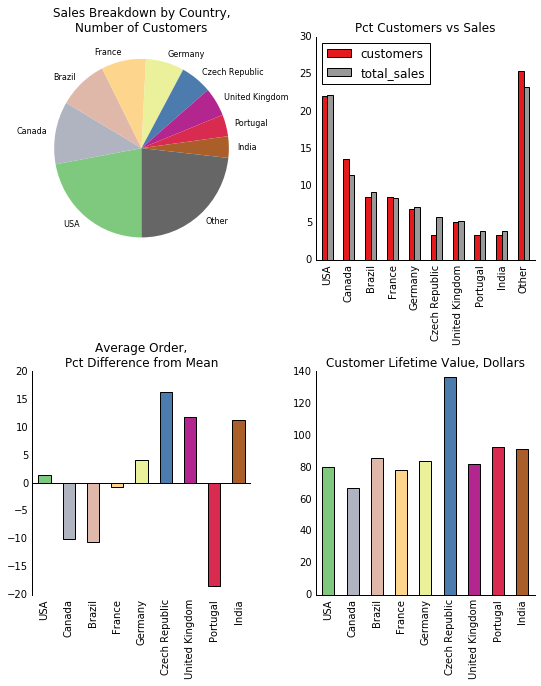

In [10]:
# taken from solution
country_metrics = run_query(q_sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, Czech, UK and India are rising up

A query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics
- number of invoices
- percentage of invoices

In [11]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


The last 2 instructions are very difficult for beginners like me. The SQL queries are complex and need to learn more before achieving the solutions. I'll use this notebook as my reference.